In [1]:
import dukit
import os
import matplotlib.pyplot as plt
import numpy as np
import logging

/home/samsc/src/qs/dukit/src/dukit/driftcorrect.py:28: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# this script assumes bunch of things in the default kwargs,
# e.g. that you want a div normalisation.

In [3]:
here = os.getcwd()
with open(
    os.path.dirname(here) + "/TEST_DATA_PATH.py", encoding="utf-8"
) as fid:
    exec(fid.read())  # reads in TEST_DATA_PATH string

In [4]:
# === SET PARAMS

DIR = TEST_DATA_PATH + "T1_test/"  # type: ignore
FILEPATH = DIR + "Spin relaxation (T1)_19"
FIG_FORMAT = "png"

# ADDITIONAL_BINS = (4, 2) # asymmetric: (x, y)
ADDITIONAL_BINS = 4
ADDITIONAL_SMOOTH = 0  # can be asymmetric, but best not.

ROI_COORDS = (-1, -1, -1, -1) # full ROI
AOI_COORDS = ((30, 40, 40, 45), (20, 20, 24, 24), (50, 50, 51, 51))
# AOI_COORDS = ((30, 40 , 40, 45),)

NORM = "true_sub"
FIT_BACKEND = "cpufit"
FIT_MODEL = dukit.ConstStretchedExp()
GUESSES = {"constant": 0.0, "power_exp": 0.7, "charac_exp_t": 1e-4, "amp_exp": 0.5}
BOUNDS = {
    "constant_bounds": (-1e-1, 1e-1),
    "power_exp_bounds": (0.0, 1.0),
    "charac_exp_t_bounds": (1e-6, 1e-2),
    "amp_exp_bounds": (0.0, 1.0),
}

# === CREATE OUTPUT DIR & set mpl rcparams
OUTPUT_DIR = f"{FILEPATH}_output/"
try:
    os.mkdir(OUTPUT_DIR)
except FileExistsError:
    pass
dukit.mpl_set_run_config()
logging.info(dukit.__version__)
with open(OUTPUT_DIR + "dukit_version.txt", "w") as fid:
    fid.write(dukit.__version__)

FIT_RES_DIR = OUTPUT_DIR + "/data/"
# set below to "" or None or False to *not* load prev fit
PREV_FIT = ""  # FIT_RES_DIR[:]

In [5]:
# === READ IN DATA
sys = dukit.CryoWidefield()
sweep_arr = sys.read_sweep_arr(FILEPATH)
sig, ref, sig_norm = sys.read_image(FILEPATH, norm=NORM)
raw_pixel_size = sys.get_raw_pixel_size(FILEPATH)

In [6]:
# === SMOOTH
if ADDITIONAL_SMOOTH:
    sig = dukit.smooth_image_stack(sig, ADDITIONAL_SMOOTH)
    ref = dukit.smooth_image_stack(ref, ADDITIONAL_SMOOTH)
    sig_norm = sys.norm(sig, ref, norm=NORM)

# === REBIN & CROP
sig_rebinned = dukit.rebin_image_stack(sig, ADDITIONAL_BINS)
pl_img = dukit.sum_spatially(sig_rebinned)
sig = dukit.crop_roi(sig_rebinned, ROI_COORDS)
del sig_rebinned  # hacky but I want to keep the memory clear
ref = dukit.crop_roi(dukit.rebin_image_stack(ref, ADDITIONAL_BINS), ROI_COORDS)
sig_norm = dukit.crop_roi(
    dukit.rebin_image_stack(sig_norm, ADDITIONAL_BINS), ROI_COORDS
)
pl_img_crop = dukit.sum_spatially(sig)

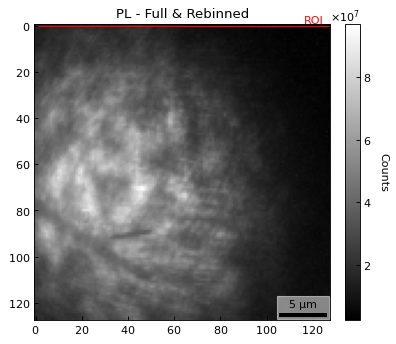

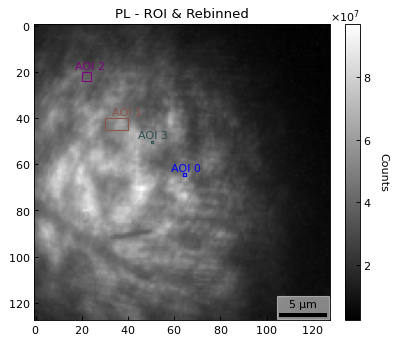

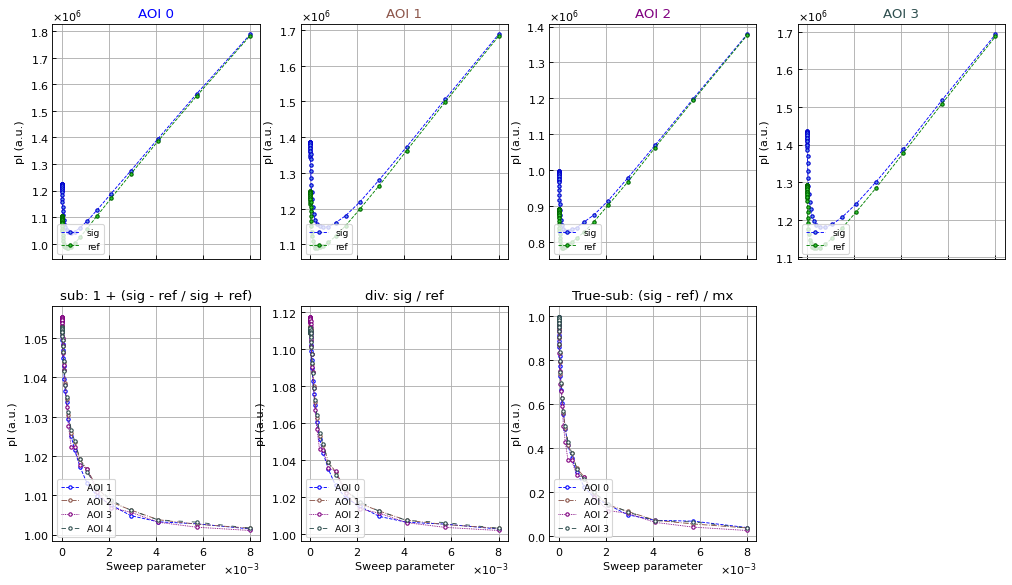

In [7]:
# === PLOT PL INFO
_ = dukit.plot.roi_pl_image(
    pl_img,
    ROI_COORDS,
    opath=OUTPUT_DIR + f"pl_full.{FIG_FORMAT}",
    show_tick_marks=True,
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
)
_ = dukit.plot.aoi_pl_image(
    pl_img_crop,
    *AOI_COORDS,
    opath=OUTPUT_DIR + f"pl_full.{FIG_FORMAT}",
    show_tick_marks=True,
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
)
_ = dukit.plot.aoi_spectra(
    sig,
    ref,
    sweep_arr,
    specpath=OUTPUT_DIR + "aoi_specta.json",
    opath=OUTPUT_DIR + f"aoi_spectra.{FIG_FORMAT}",
    *AOI_COORDS,
)

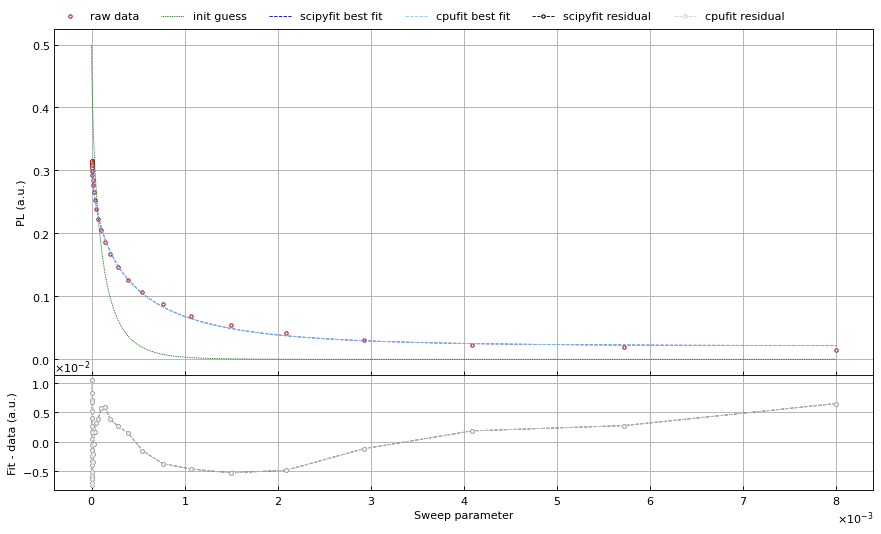

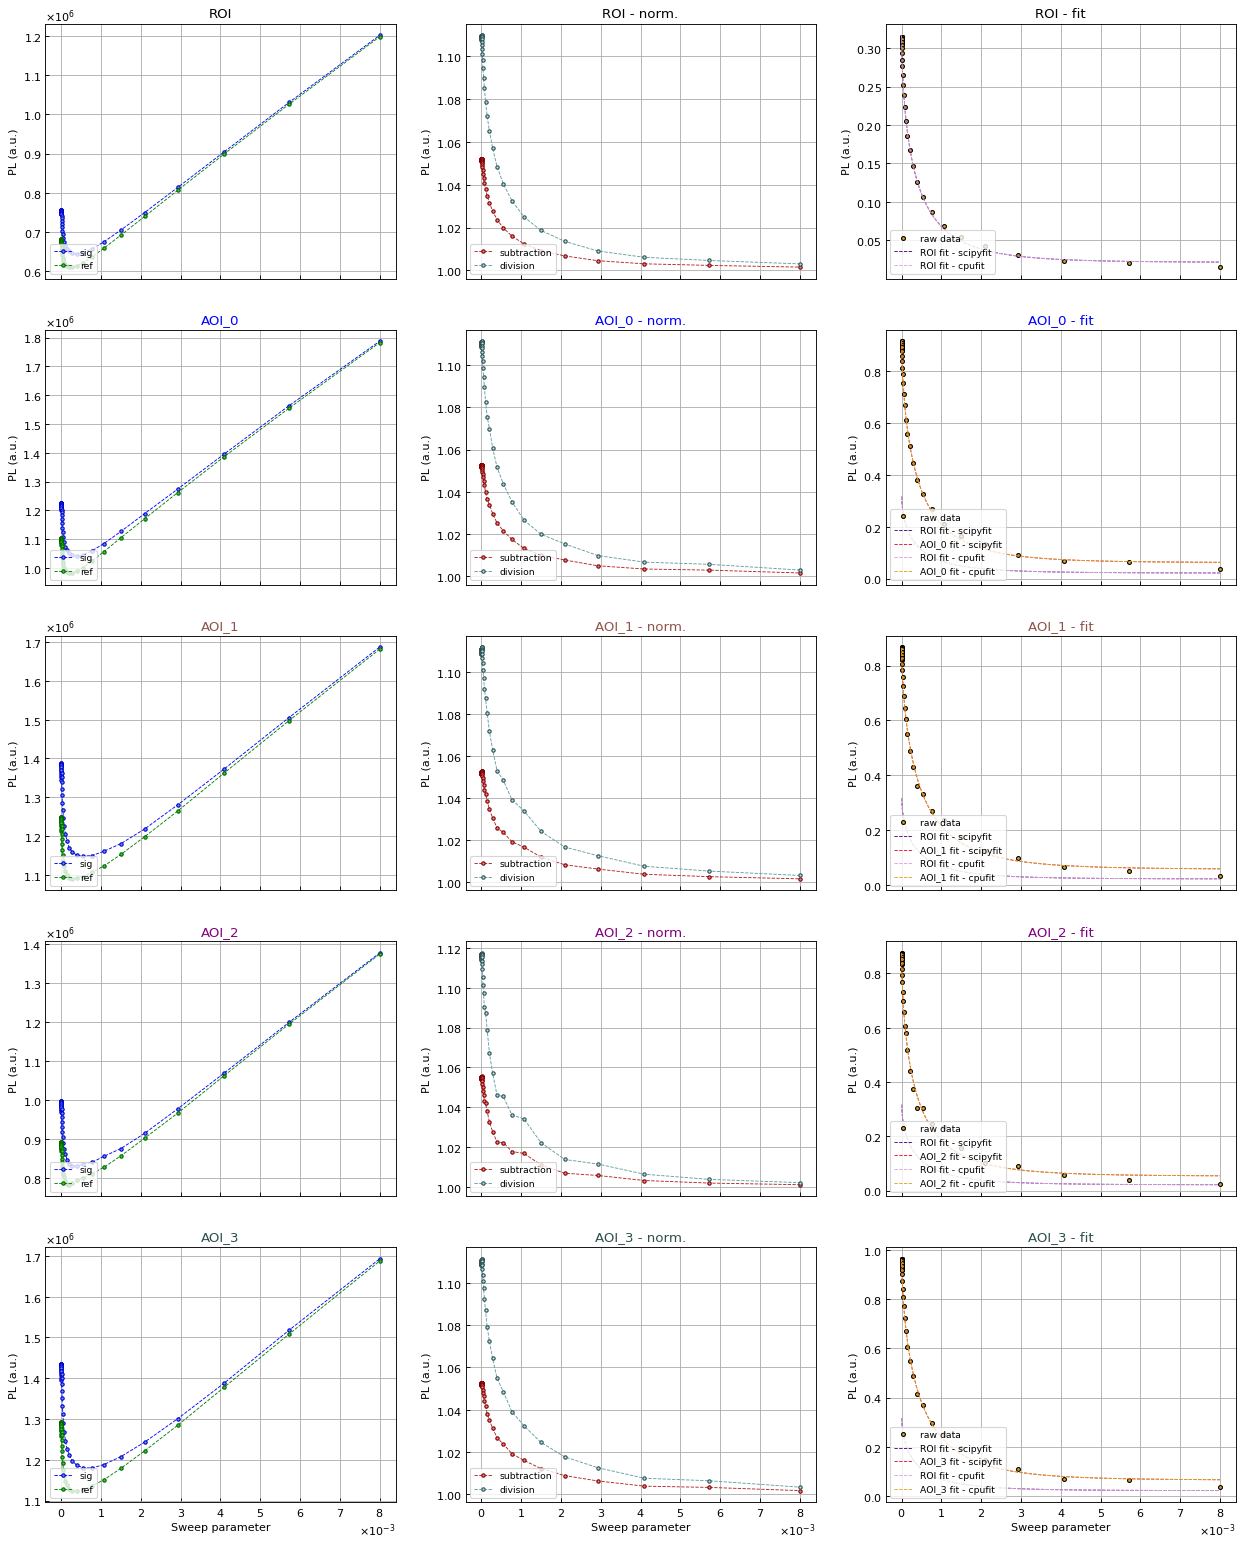

In [9]:
# fit_roi,  roi_avg_fits
roi_fit_results = dukit.fit_roi(
    sig,
    ref,
    sweep_arr,
    FIT_MODEL,
    GUESSES,
    BOUNDS,
    opath=OUTPUT_DIR + f"roi_avg_fit.json",
    norm=NORM
)
_ = dukit.plot.roi_avg_fits(
    roi_fit_results, opath=OUTPUT_DIR + f"roi_avg_fits.{FIG_FORMAT}"
)

# fit_aois, aoi_avg_fits
aoi_fit_results = dukit.fit_aois(
    sig,
    ref,
    sweep_arr,
    FIT_MODEL,
    GUESSES,
    BOUNDS,
    *AOI_COORDS,
    opath=OUTPUT_DIR + f"aoi_fits.json",
    norm=NORM
)
_ = dukit.plot.aoi_spectra_fit(
    aoi_fit_results,
    roi_fit_results,
    sig.shape[:-1],
    *AOI_COORDS,
    opath=OUTPUT_DIR + f"aoi_spectra_fit.{FIG_FORMAT}",
)


In [ ]:
# fit_all_pixels_pl
if PREV_FIT:
    fit_image_results = dukit.load_fit_results(PREV_FIT, FIT_MODEL)
else:
    fit_image_results = dukit.fit_all_pixels(
        FIT_BACKEND,
        sig_norm,
        sweep_arr,
        FIT_MODEL,
        GUESSES,
        BOUNDS,
        roi_fit_results[FIT_BACKEND],
        odir=FIT_RES_DIR,
    )

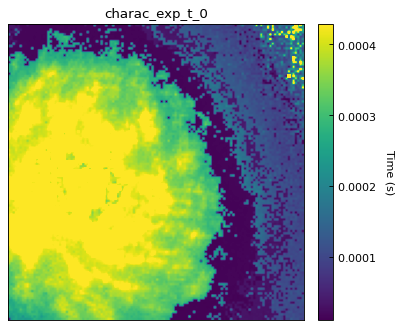

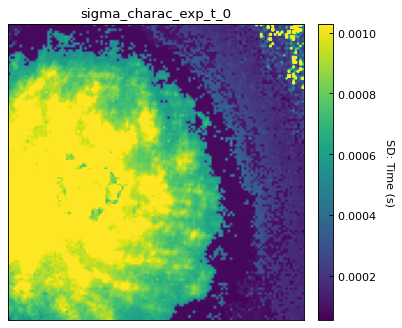

In [12]:
# pl_param_images
_ = dukit.plot.pl_param_images(
    FIT_MODEL,
    fit_image_results,
    "charac_exp_t",
    opath=OUTPUT_DIR + f"charac_exp_t.{FIG_FORMAT}",
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
    c_range_type="percentile",
    c_range_values=(0, 80)
)

_ = dukit.plot.pl_param_images(
    FIT_MODEL,
    fit_image_results,
    "sigma_charac_exp_t",
    opath=OUTPUT_DIR + f"sigma_charac_exp_t.{FIG_FORMAT}",
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
    errorplot=True,
    c_range_type="percentile",
    c_range_values=(0, 80)
)